<a href="https://colab.research.google.com/github/djakesa/AE-VAE-GAN-CelebA/blob/main/VAE_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#On connecte mon drive au google collab

In [1]:
from google.colab import drive
import os
import shutil

# Démontage s'il est déjà monté
try:
    !fusermount -u /content/drive
except:
    pass

# Suppression du dossier de montage s'il reste
if os.path.exists('/content/drive'):
    shutil.rmtree('/content/drive', ignore_errors=True)

# Montage propre
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Importer la BDD via google drive

- J'ai déjà importé des photos de la BDD CelebA pour la suite lorsque j'ai construit mon AE à : /content/drive/MyDrive/img_align_celeba/img_align_celeba

- On va quand même tester si c'est ok avec ce path

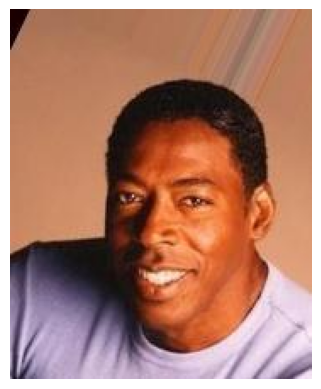

In [ ]:
import cv2
import matplotlib.pyplot as plt

img= cv2.imread('/content/drive/MyDrive/img_align_celeba/img_align_celeba/002000.jpg')
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(img)
plt.axis('off')
plt.show()

#On va maintenant construire le VAE

In [26]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer
import tensorflow as tf
import numpy as np

# Couche personnalisée pour le sampling + ajout de la KL divergence
class Sampling(Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(mu), mean=0.0, stddev=1.0)
        z = mu + tf.exp(0.5 * log_var) * epsilon

        # Calcul de la divergence KL
        kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=1)
        self.add_loss(tf.reduce_mean(kl_loss))

        return z

class VAE():
    def __init__(self,
                 input_dim,
                 encoder_conv_filters,
                 encoder_conv_kernel_size,
                 encoder_conv_strides,
                 decoder_conv_t_filters,
                 decoder_conv_t_kernel_size,
                 decoder_conv_t_strides,
                 z_dim,
                 use_batch_norm=False,
                 use_dropout=False):

        self.name = 'variational_autoencoder'

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    def _build(self):
        ## ENCODER
        encoder_input_layer = Input(shape=self.input_dim, name="encoder_input_layer")
        x = encoder_input_layer

        for i in range(self.n_layers_encoder):
            x = Conv2D(filters=self.encoder_conv_filters[i],
                       kernel_size=self.encoder_conv_kernel_size[i],
                       strides=self.encoder_conv_strides[i],
                       padding='same',
                       name='encoder_conv_' + str(i))(x)
            if self.use_batch_norm:
                x = BatchNormalization()(x)
            x = LeakyReLU()(x)
            if self.use_dropout:
                x = Dropout(rate=0.25)(x)

        self.shape_before_flattening = K.int_shape(x)[1:]

        x = Flatten()(x)
        self.mu = Dense(self.z_dim, name='mu')(x)
        self.log_var = Dense(self.z_dim, name='log_var')(x)

        z = Sampling(name='encoder_output')([self.mu, self.log_var])
        self.encoder = Model(encoder_input_layer, z)

        ## DECODER
        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')
        x = Dense(np.prod(self.shape_before_flattening))(decoder_input)
        x = Reshape(self.shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            x = Conv2DTranspose(filters=self.decoder_conv_t_filters[i],
                                kernel_size=self.decoder_conv_t_kernel_size[i],
                                strides=self.decoder_conv_t_strides[i],
                                padding='same',
                                name='decoder_conv_t_' + str(i))(x)
            if i < self.n_layers_decoder - 1:
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                x = LeakyReLU()(x)
                if self.use_dropout:
                    x = Dropout(rate=0.25)(x)
            else:
                x = Activation('sigmoid')(x)

        self.decoder = Model(decoder_input, x)
        model_output = self.decoder(self.encoder(encoder_input_layer))
        self.model = Model(encoder_input_layer, model_output)

    def compile(self, learning_rate, r_loss_factor):
        self.learning_rate = learning_rate

        def vae_r_loss(y_true, y_pred):
            r_loss = K.mean(K.square(y_true - y_pred), axis=[1, 2, 3])
            return r_loss_factor * r_loss

        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer, loss=vae_r_loss, metrics=[vae_r_loss])

    def train(self, x_train, batch_size, epochs, initial_epoch=0):
        self.model.fit(x_train, x_train,
                       batch_size=batch_size,
                       shuffle=True,
                       epochs=epochs,
                       initial_epoch=initial_epoch)


In [3]:
# Chargement de 1000 images CelebA depuis le dossier extrait
import cv2
import numpy as np
import os

image_dir = '/content/drive/MyDrive/img_align_celeba/img_align_celeba'
image_paths = sorted([
    os.path.join(image_dir, fname)
    for fname in os.listdir(image_dir)
    if fname.endswith('.jpg')
])[:1000]  # pour un entraînement rapide

def load_images(paths):
    images = []
    for path in paths:
        img = cv2.imread(path)
        # Check if image was loaded correctly
        if img is None:
            print(f"Error loading image: {path}")
            continue  # Skip this image and proceed with the next
        img = cv2.resize(img, (128, 128))  # <<< réduction de taille ici
        img = img.astype('float32') / 255.0
        images.append(img)
    # Check if any images were loaded
    if not images:  # If images list is empty
        raise ValueError("No images were loaded. Check image paths and formats.")
    return np.array(images)

x_train = load_images(image_paths)

Error loading image: /content/drive/MyDrive/img_align_celeba/img_align_celeba/000165.jpg


In [27]:
vae = VAE(
    input_dim = (128,128,3)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,3]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 200
)

In [29]:
vae.encoder.summary()
vae.decoder.summary()
vae.model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input_layer │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_0      │ (None, 128, 128,  │        896 │ encoder_input_la… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_29      │ (None, 128, 128,  │          0 │ encoder_conv_0[0… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_1      │ (None, 64, 64,    │     18,496 │ leaky_re_lu_29[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_30      │ (None, 64, 64,    │          0 │ encoder_conv_1[0… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_2      │ (None, 32, 32,    │     36,928 │ leaky_re_lu_30[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_31      │ (None, 32, 32,    │          0 │ encoder_conv_2[0… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_3      │ (None, 32, 32,    │     36,928 │ leaky_re_lu_31[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_32      │ (None, 32, 32,    │          0 │ encoder_conv_3[0… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 65536)     │          0 │ leaky_re_lu_32[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mu (Dense)          │ (None, 200)       │ 13,107,400 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_var (Dense)     │ (None, 200)       │ 13,107,400 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_output      │ (None, 200)       │          0 │ mu[0][0],         │
│ (Sampling)          │                   │            │ log_var[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,308,048 (100.36 MB)

 Trainable params: 26,308,048 (100.36 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 65536)          │    13,172,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_0                │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_33 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_1                │ (None, 64, 64, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_34 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_2                │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_35 (LeakyReLU)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_3                │ (None, 128, 128, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128, 128, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,265,923 (50.61 MB)

 Trainable params: 13,265,923 (50.61 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input_layer             │ (None, 128, 128, 3)    │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_12 (Functional)      │ (None, 200)            │    26,308,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_13 (Functional)      │ (None, 128, 128, 3)    │    13,265,923 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,573,971 (150.96 MB)

 Trainable params: 39,573,971 (150.96 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000

vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

BATCH_SIZE = 32
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0


In [31]:
vae.train(
    x_train=x_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    initial_epoch=INITIAL_EPOCH
)


Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - loss: 94.9443 - vae_r_loss: 89.6250
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 69.0630 - vae_r_loss: 62.0357
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 56.5116 - vae_r_loss: 48.1393
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 55.1582 - vae_r_loss: 46.6374
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 53.7237 - vae_r_loss: 44.2498
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 52.6584 - vae_r_loss: 43.1785
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 53.1370 - vae_r_loss: 43.0871
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 51.5517 - vae_r_loss: 41.0343
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 51.9362 - vae_r_loss: 41.8371
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 50.7472 - vae_r_loss: 41.2495
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 51.7801 - vae_r_loss: 41.6679
Epoch 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


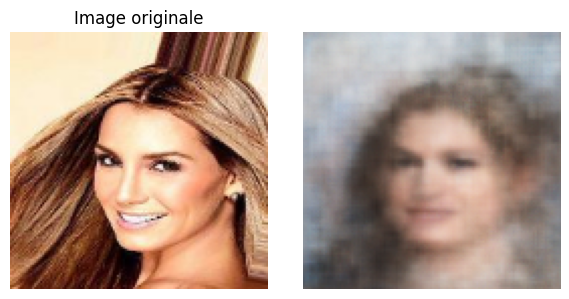

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


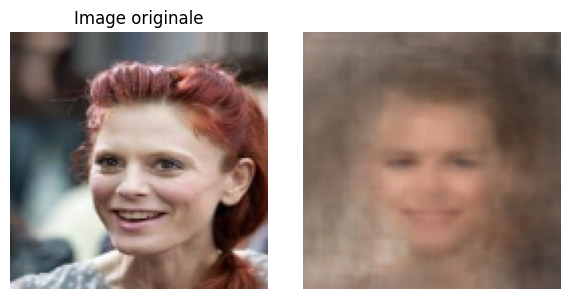

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


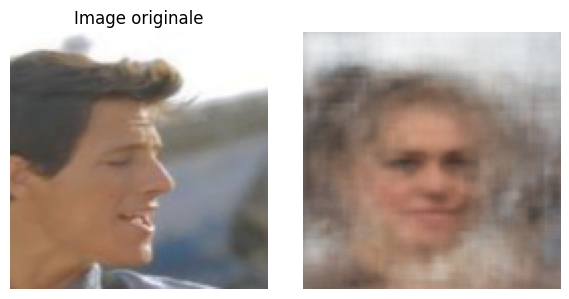

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


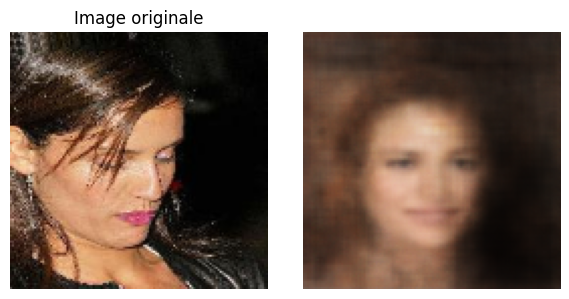

In [34]:
import matplotlib.pyplot as plt

for i in range(4):
    test_img = x_train[i]
    test_img_input = np.expand_dims(test_img, axis=0)

    reconstructed_img = vae.model.predict(test_img_input)[0]  # ou autoencodeur.model si renommé

    plt.figure(figsize=(6, 3))

    # Image originale
    plt.subplot(1, 2, 1)
    plt.imshow(test_img[..., ::-1])  # BGR → RGB
    plt.title('Image originale')
    plt.axis('off')

    # Image reconstruite
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_img)
    plt.imshow(reconstructed_img[..., ::-1])  # BGR → RGB
    plt.axis('off')

    plt.tight_layout()
    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


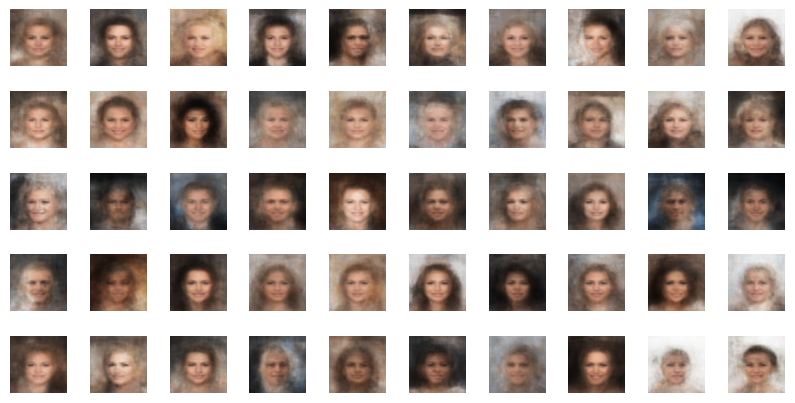

In [35]:
grid_size = 10
grid_depth = 5
z_random = np.random.normal(0, 1, size=(grid_size * grid_depth, vae.z_dim))

reconstructed_images = vae.decoder.predict(z_random)

fig = plt.figure(figsize=(grid_size, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size * grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconstructed_images[i, ..., ::-1])  # pas de cmap ici : c’est du RGB
plt.show()
